# Some Importes

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load and Explore Time Series Data

### Handling initial data file

In [137]:
df = pd.read_excel("rawdata\online_retail_II.xlsx", parse_dates=["InvoiceDate"], sheet_name=[0,1])

In [138]:
#Check number of rows and columns from the first spreadsheet "Year 2009-2010"
df[0].shape

(525461, 8)

In [139]:
#Check number of rows and columns from the second spreadsheet "Year 2010-2011"
df[1].shape

(541910, 8)

In [140]:
#Merge booth sheets into one dataframe
df_retail_data = pd.concat([df[0], df[1]])

In [141]:
#Check number of rows and columns for whole dataframe
df_retail_data.shape

(1067371, 8)

In [142]:
#See the first 5 records
df_retail_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In the next commands we will explore the data, in order to help us to define the objective

In [143]:
# Total of products
len(df_retail_data['StockCode'].unique())

5305

In [144]:
# List of countries
df_retail_data['Country'].unique()

array(['United Kingdom', 'France', 'USA', 'Belgium', 'Australia', 'EIRE',
       'Germany', 'Portugal', 'Japan', 'Denmark', 'Nigeria',
       'Netherlands', 'Poland', 'Spain', 'Channel Islands', 'Italy',
       'Cyprus', 'Greece', 'Norway', 'Austria', 'Sweden',
       'United Arab Emirates', 'Finland', 'Switzerland', 'Unspecified',
       'Malta', 'Bahrain', 'RSA', 'Bermuda', 'Hong Kong', 'Singapore',
       'Thailand', 'Israel', 'Lithuania', 'West Indies', 'Lebanon',
       'Korea', 'Brazil', 'Canada', 'Iceland', 'Saudi Arabia',
       'Czech Republic', 'European Community'], dtype=object)

In [145]:
# Total of countries
len(df_retail_data['Country'].unique())

43

In [146]:
# Total of clients
len(df_retail_data['Customer ID'].unique())

5943

In [147]:
#Checking null values
df_retail_data.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

# Feature Engineering for Time Series

In [148]:
#Manipulation
#Make the cancel invoices (Invoice starting with 'C') to be considered as negative, then all further aggregation will reflect the real amounts
df_retail_data.loc[df_retail_data['Invoice'].str.startswith('C', na=False),'Price'] *= -1

In [149]:
#Manipulation
#Create calculated column: TotalAmount = Quantity * Price
df_retail_data['TotalAmount'] = df_retail_data['Quantity'] * df_retail_data['Price']

In [150]:
#Create another dataframe indexed by the date, to do some exploratory tests with different frequencies
df_retail_data_indexed = df_retail_data[['InvoiceDate','TotalAmount']]
df_retail_data_indexed.index = df_retail_data_indexed['InvoiceDate']

In [151]:
#Monthly data
df_grouped_monthly = df_retail_data_indexed.groupby(pd.Grouper(freq='M'))

In [152]:
#Columns count - by month
df_grouped_monthly.sum()

,TotalAmount
InvoiceDate,
2009-12-31,851524.410
2010-01-31,681384.112
2010-02-28,573588.046
2010-03-31,901291.501
2010-04-30,665288.832
2010-05-31,704394.890
2010-06-30,824753.670
2010-07-31,638125.940
2010-08-31,737773.480


In [153]:
#Daily data
df_grouped_daily = df_retail_data_indexed.groupby(pd.Grouper(freq='D'))

In [154]:
#Columns count - by day
df_grouped_daily.sum()

,TotalAmount
InvoiceDate,
2009-12-01,55853.97
2009-12-02,63941.43
2009-12-03,79982.77
2009-12-04,41119.44
2009-12-05,9803.05
...,...
2011-12-05,119732.60
2011-12-06,59198.05
2011-12-07,75802.10


In [155]:
#Hourly data
df_grouped_hourly = df_retail_data_indexed.groupby(pd.Grouper(freq='1h'))

In [156]:
#Columns count - by hour
df_grouped_hourly.sum()

,TotalAmount
InvoiceDate,
2009-12-01 07:00:00,651.10
2009-12-01 08:00:00,0.00
2009-12-01 09:00:00,5165.23
2009-12-01 10:00:00,4921.76
2009-12-01 11:00:00,6398.01
...,...
2011-12-09 08:00:00,3581.93
2011-12-09 09:00:00,340181.21
2011-12-09 10:00:00,19888.11


# Problem Definition

The group decided to go ahead with the following time series study: **"Predict daily billing amount"**

In [157]:
#Use the data from the daily frequency as our main source
df_final_data = df_grouped_daily.sum()

## Create CSV file

In [158]:
#Check the structure
df_final_data.head()

,TotalAmount
InvoiceDate,
2009-12-01,55853.97
2009-12-02,63941.43
2009-12-03,79982.77
2009-12-04,41119.44
2009-12-05,9803.05


In [159]:
#Check the dataframe size
df_final_data.shape

(739, 1)

In [160]:
#Rename the 'InvoiceDate' Column to 'Date' (index) and 'TotalAmount' to 'Amount'
df_final_data=df_final_data.rename(columns = {'TotalAmount':'Amount'})
df_final_data.index.names = ['Date']

In [161]:
df_final_data.head()

,Amount
Date,
2009-12-01,55853.97
2009-12-02,63941.43
2009-12-03,79982.77
2009-12-04,41119.44
2009-12-05,9803.05


In [162]:
#Create CSV with daily amounts removind the days without sales (should we?)
df_final_data[df_final_data['Amount'] > 0].to_csv("./data/1-retail_daily_amount.csv")

# Data Vizualization

In [163]:
#Let's read the same file as a time series
ts_data = pd.read_csv('./data/1-retail_daily_amount.csv', index_col='Date', parse_dates=True)

In [164]:
ts_data.head()

,Amount
Date,
2009-12-01,55853.97
2009-12-02,63941.43
2009-12-03,79982.77
2009-12-04,41119.44
2009-12-05,9803.05


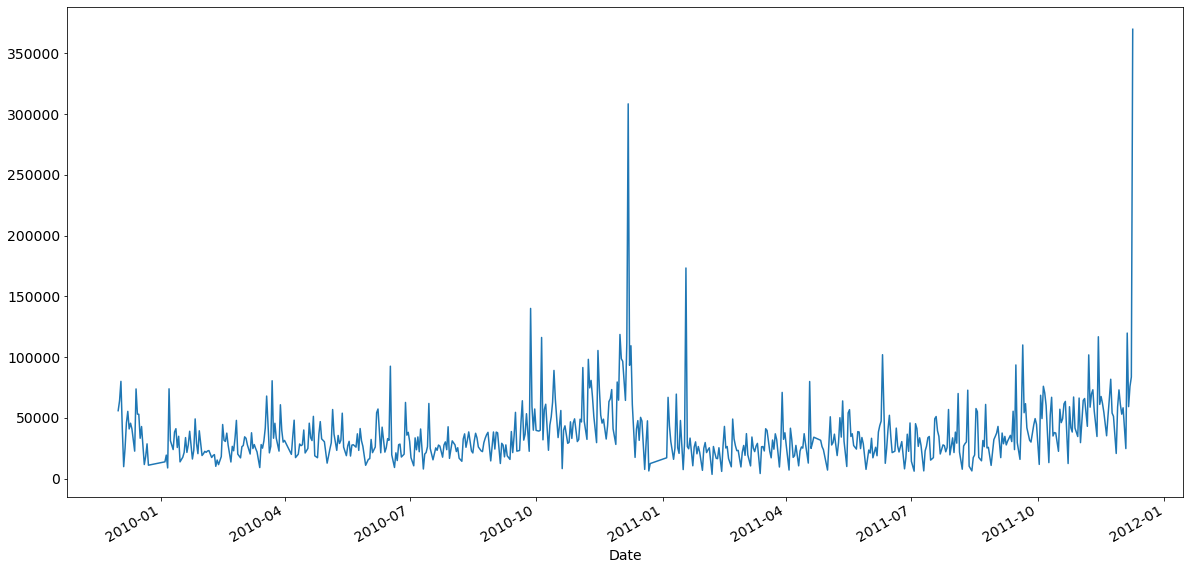

In [165]:
#Plot the time series

plt.figure(figsize=(20,10)) 
ts_data.Amount.plot().get_figure()
plt.show()

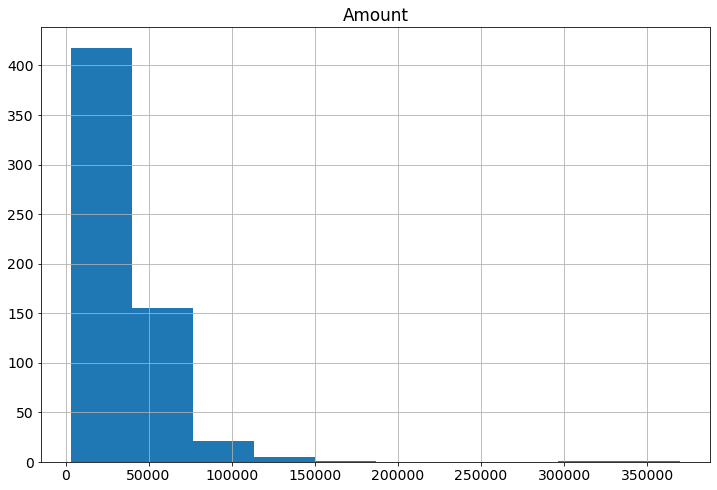

In [166]:
#Plot the histogram

ts_data.hist()
plt.show()

# Log Transform

In [167]:
#Log the Amount to make it more stable
log_data=ts_data
log_data['Amount'] = np.log(log_data['Amount'])

In [173]:
log_data.head()

,Amount
Date,
2009-12-01,10.930496
2009-12-02,11.065723
2009-12-03,11.289567
2009-12-04,10.624236
2009-12-05,9.190449


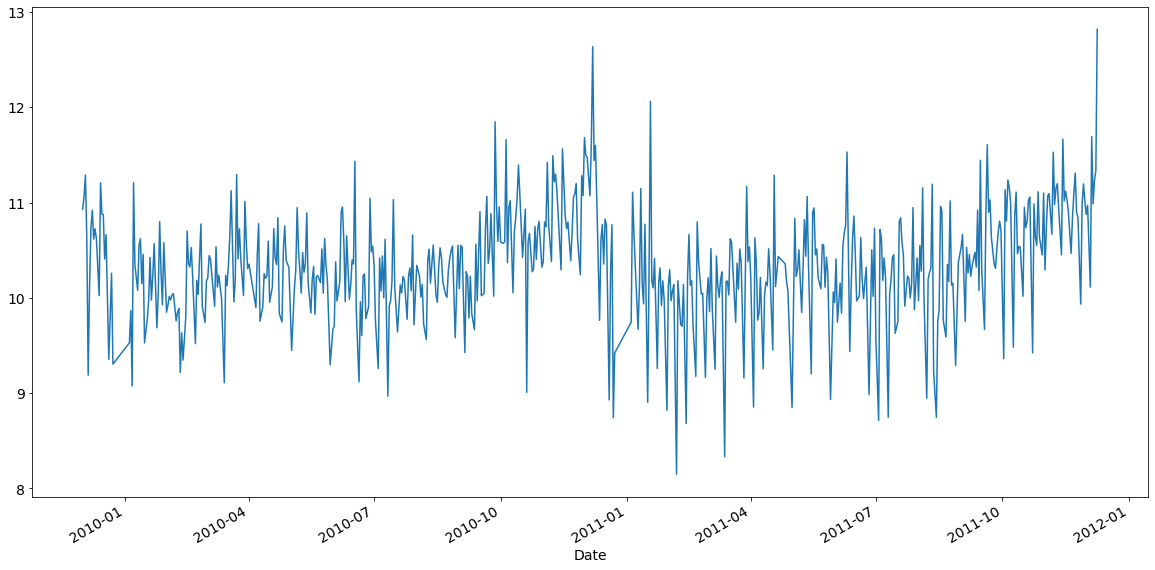

In [169]:
#Plot the time series with log
plt.figure(figsize=(20,10)) 
log_data.Amount.plot().get_figure()
plt.show()

# Moving Average and Smoothing

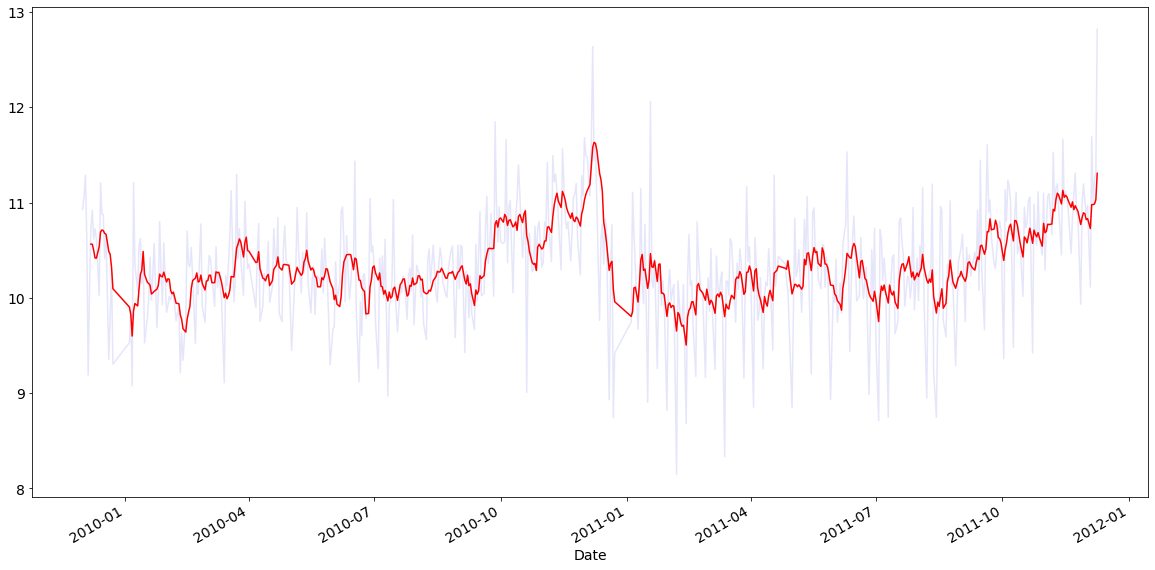

In [130]:
# Rolling - Now let's use the moving average with 7 days, to smooth the data reflecting the weekly tendency
plt.figure(figsize=(20,10)) 

log_data_roll = log_data.rolling(window=7)#7 days
log_data_r_mean = log_data_roll.mean()

ts_data.Amount.plot(color='lavender')#Old data
log_data_r_mean.Amount.plot(color='red')#Moving-average data

plt.show()

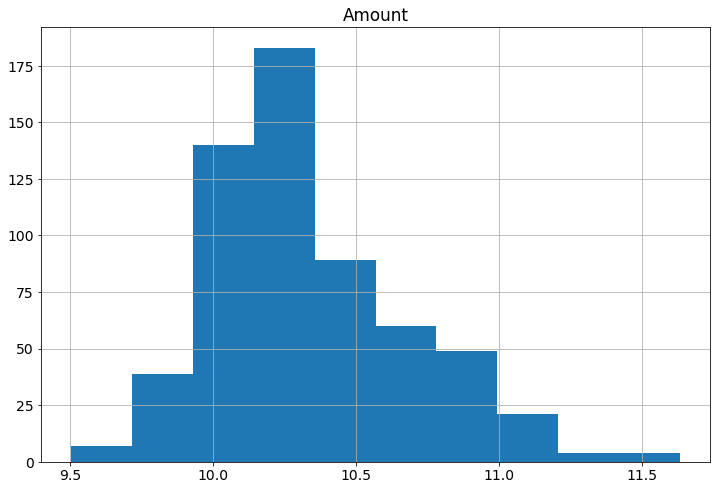

In [131]:
#Plot the histogram after log and smoothing

log_data_r_mean.hist()
plt.show()

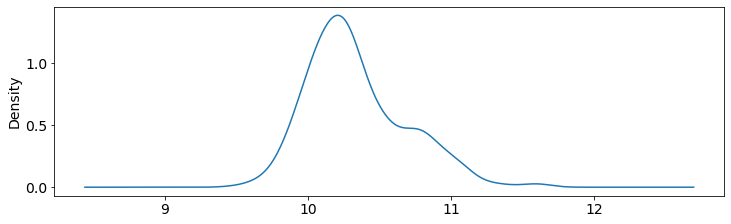

In [132]:
# density plot of time series
from pandas import read_csv
from matplotlib import pyplot
log_data_r_mean.hist()
pyplot.subplot(212)
ts_data_r_mean.Amount.plot(kind='kde')
pyplot.show()

In [175]:
#Create the csv file with the adjustments
log_data_r_mean[log_data_r_mean['Amount'] > 0].to_csv("./data/2-steady_retail_daily_amount.csv")

In [176]:
#Let's read the same file as a time series
log_data_r_mean = pd.read_csv('./data/2-steady_retail_daily_amount.csv', index_col='Date', parse_dates=True)

# Decomposing Time Series

Time series decomposition is a combination of level, trend, seasonality, and noise components. Decomposition can be useful for better understanding problems during time series analysis and forecasting. 
Decomposition is used for time series analysis, and as
an analysis tool it can be used to inform forecasting models on our problem. Helps in terms of modeling complexity and specially un terms of how to capture each componete (level, trend, seasonality, and noise) in a given model. 


### Application of Additive Model

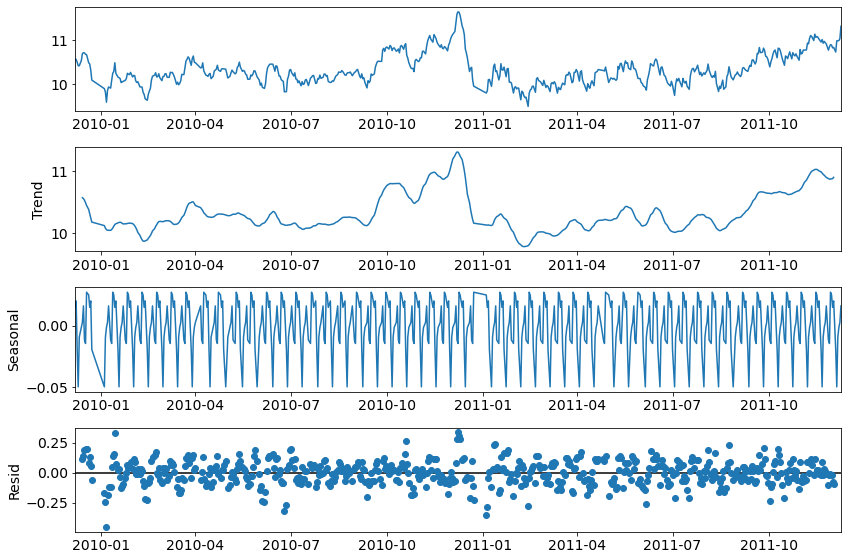

In [179]:
# components of time series

from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.rcParams.update({'font.size': 14})
# freq is the number of data points in a repeated cycle
result = seasonal_decompose(log_data_r_mean, model='additive',period=12)
result.plot()
plt.show()

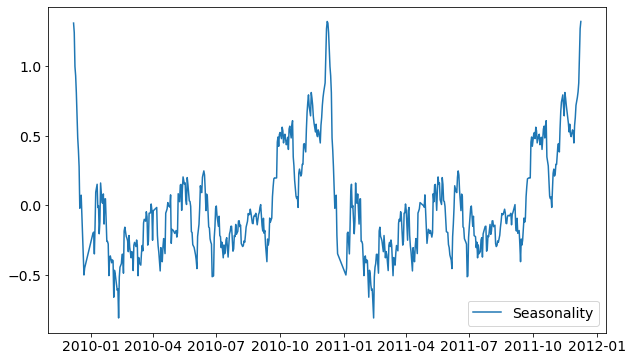

In [206]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.figure(figsize=(10,6))

decomposition = seasonal_decompose(log_data_r_mean,model='additive',period=298)
seasonal = decomposition.seasonal
#plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.show()

Decomposing time series, we can see a clear seasonality, with the sales increasing along the year until the Christmas time and decreasing abruptly just after that period.  

# Stationarity - Unit root test (ADF test)

### Original data

In [203]:
from statsmodels.tsa.stattools import adfuller
test1 = adfuller(ts_data, autolag='AIC')
print("p-value =", test1[1])

if test1[1]> 0.05:
    print("We do not reject the H0: non-stationary time series <-> we have a unit root")

p-value = 0.2687825234138247
We do not reject the H0: non-stationary time series <-> we have a unit root


P valeu is biger than 0.05, we don't regect the null hipostses, the null hipotisis statte that the time siries has a unit root. The serie is non stationary, the mean and variance are not constant, we are going to make the Serie stationary .

### Log data

In [207]:
from statsmodels.tsa.stattools import adfuller
test2 = adfuller(log_data_r_mean, autolag='AIC')
print("p-value =", test2[1])

if test2[1]> 0.05:
    print("We do not reject the H0: non-stationary time series <-> we have a unit root")

p-value = 0.44117153286853816
We do not reject the H0: non-stationary time series <-> we have a unit root


P valeu is biger than 0.05, we don't regect the null hipostses, the null hipotisis statte that the time siries has a unit root. The serie is non stationary, the mean and variance are not constant, we are going to make the Serie stationary .

## Stationarize data: log-returns (first difference of log-values)

In [211]:
log_returns = np.log(ts_data).diff().dropna()
log_returns.head()

,Amount
Date,
2009-12-02,0.012296
2009-12-03,0.020027
2009-12-04,-0.060741
2009-12-05,-0.144973
2009-12-06,0.096648


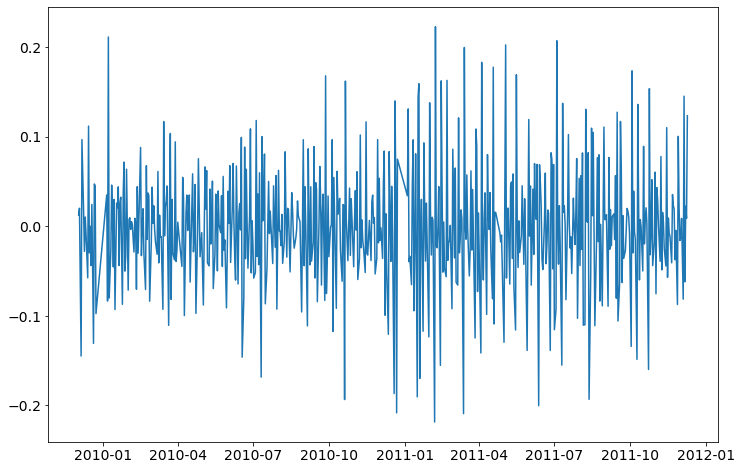

In [212]:
plt.plot(log_returns)
plt.show()

We were able to clear the trend, but we still have the seasonality.

In [222]:
## ADF unit root test
test3 = adfuller(log_returns, autolag='AIC')
test3_result = pd.Series(adf3[0:4], index=['ADF Test Statistic','P-Value','# Lags Used',
                                        '# Observations Used'])
print(test3_result)
print('')
if test3[1]> 0.05:
    print("We do not reject the H0: non-stationary time series <-> we have a unit root")
else:
    print("We reject the H0: stationary time series <-> we don't have a unit root")

ADF Test Statistic    -9.121258e+00
P-Value                3.200642e-15
# Lags Used            1.600000e+01
# Observations Used    5.840000e+02
dtype: float64

We reject the H0: stationary time series <-> we don't have a unit root


P-Value is smaller than our 5% significance level, therefore we reject the null hypothesis that unit root does exist, so the log_returns time series is stationar. We have an integrated stationary Serie of order 1. 

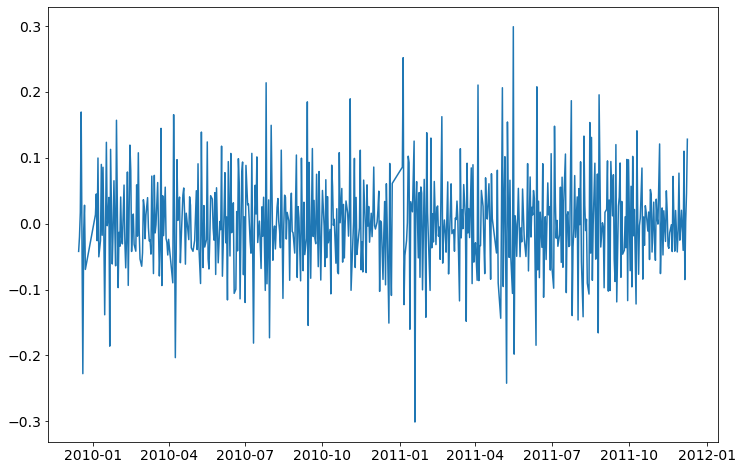

In [223]:
# Due to both trend and seasonal components, we apply one non-seasonal diff() and one seasonal differencing diff(12).
df_diff =  np.log(ts_data).diff().diff(12).dropna()
plt.plot(df_diff)
plt.show()

Now we can see that we don't have trend neither seasonality.

In [224]:
#ts_data= original data
#log_data_r_mean = log data with Moving Average and Smoothing 
#log_returns = log and returns (no trend but has seasonality)
#Df_diff = (no trend and no seasonality)

## Correlogram: ACF and PACF

In [225]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

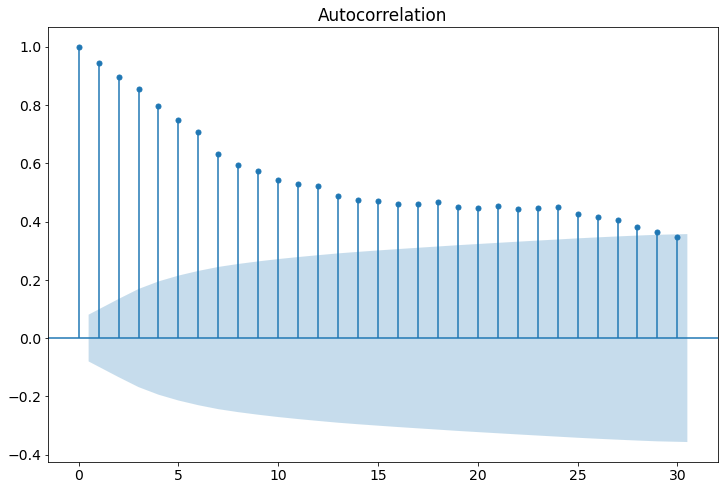

In [226]:
plot_acf(log_data_r_mean, lags=30, alpha=0.05)
plt.show()

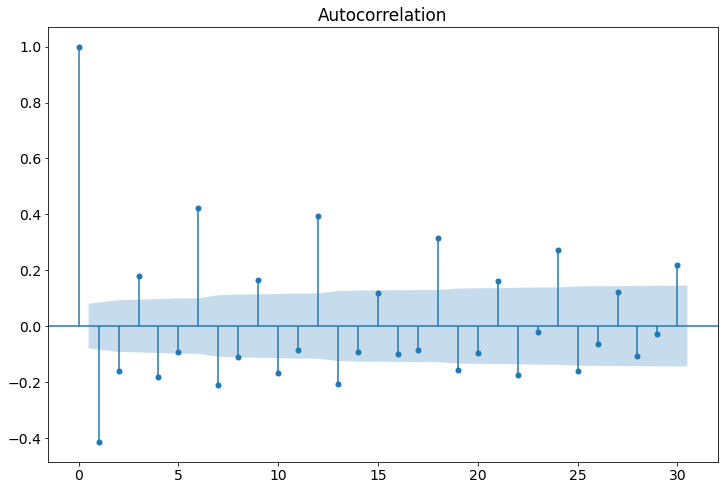

In [227]:
plot_acf(log_returns, lags=30, alpha=0.05)
plt.show()

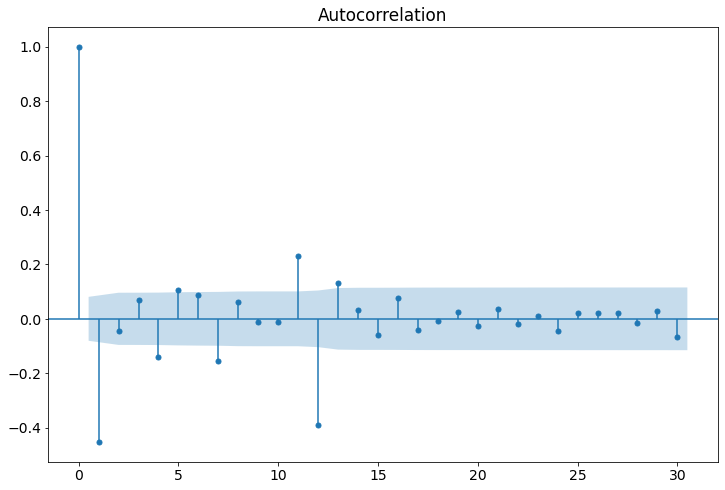

In [228]:
plot_acf(df_diff, lags=30, alpha=0.05)
plt.show()